# NEXUS tool: case study for the Souss-Massa basin - energy demand calculations
In this notebook a case study for the Souss-Massa basin is covered using the `nexus_tool` package. The water requirements for agricultural irrigation, residential, industrial and tourism use were previously calculated using the Water Evaluation and Planning System (WEAP) model. In this case study, the energy requirements for groundwater pumping, wastewater treatment, desalination of seawater and pumping for water conveyance are estimated.

First import the package by running the following block:

In [302]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [303]:
%autoreload
import os
import nexus_tool
from nexus_tool.weap_tools import create_folder
from nexus_tool.weap_tools import create_learning_curve
# import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# from pandas.plotting import register_matplotlib_converters
import plotly.express as px
# register_matplotlib_converters()

In [304]:
scenarios = ['Reference']
load_folder = os.path.join('Data - Souss-Massa', 'Merged data')
results_folder = os.path.join('Morocco dashboard', 'data')
create_folder(results_folder)
for scenario in scenarios:
    scenario_folder = os.path.join(load_folder, scenario)
    create_folder(os.path.join(results_folder, scenario))
    for sub_scenario in os.listdir(scenario_folder):
        sub_scenario_folder = os.path.join(scenario_folder, sub_scenario)
        create_folder(os.path.join(results_folder, scenario, sub_scenario))
        for level in os.listdir(sub_scenario_folder):
            output_folder = os.path.join(results_folder, scenario, sub_scenario, level)
            load_data = os.path.join(sub_scenario_folder, level)
            create_folder(output_folder)
            
            #Define the path to read the scenario input data and reads it in
            file_path = os.path.join(load_data, 'demand_data.csv')
            df = nexus_tool.read_csv(file_path)
            
            #Creates the nexus model with the input dataframe
            souss_massa = nexus_tool.Model(df)
            
            #Define the diameter of the pipelines. The first is general for all and the following specific for each case
            souss_massa.df['Pipe_diameter'] = 0.4
            souss_massa.df.loc[souss_massa.df['type'].str.contains('GW'), 'Pipe_diameter'] = 0.6
            souss_massa.df.loc[souss_massa.df['type'].str.contains('Pipeline'), 'Pipe_diameter'] = 1.2
            souss_massa.df.loc[souss_massa.df['type'].str.contains('DS'), 'Pipe_diameter'] = 1
            
            #Define the variable to take into account for elevation difference and lenght of pipelines
            souss_massa.elevation = 'elevation_diff' #for the case of GW, the elevation_diff is set to be the wtd
            souss_massa.L = 'distance' #for the case of GW, the distance is set to be the wtd
            
            #Defines the name of the variable for Peak Water Demand and Seasonal Water demand (monthly)
            souss_massa.pwd = 'pwd'
            souss_massa.sswd = 'sswd'
            souss_massa.df.rename(columns={'value': 'sswd'}, inplace=True)
            souss_massa.peak_Q = souss_massa.pwd #This is a work around so we are able to calculat all energy demand with the SW_pumping method
            souss_massa.avg_Q = souss_massa.sswd #This is a work around so we are able to calculat all energy demand with the SW_pumping method
            souss_massa.swpp_e = 'swpp_e'
            souss_massa.pd_e = 'swpp_e'
            souss_massa.swpa_e = 'swpa_e'
            souss_massa.pumping_hours_per_day = 10
            souss_massa.SWpump_eff = 0.6
            
            #Defines the PWD. It is defined as double the seasonal demand for agricultural sites
            souss_massa.df[souss_massa.pwd] = souss_massa.df[souss_massa.sswd] / 3600 / 30 / souss_massa.pumping_hours_per_day #to convert to cubic meter per second [m3/s]
            souss_massa.df.loc[souss_massa.df['type']=='Agriculture', souss_massa.pwd] *= 2
            
            #Calculates some required parameters
            souss_massa.get_A(inplace=True)
            souss_massa.get_V(inplace=True, axis=0)
            souss_massa.get_Re(inplace=True, axis=0)
            souss_massa.get_f(inplace=True, axis=0)

            souss_massa.get_sw_tdh(inplace = True, axis=0) #this is called sw but it calculets for gw too. I still need to change the names
            souss_massa.get_SWpumping_energy(inplace = True, axis=0) #the same here
            
            souss_massa.df.loc[souss_massa.df.swpp_e<0, souss_massa.swpp_e] = 0
            souss_massa.df.loc[souss_massa.df.swpa_e<0, souss_massa.swpa_e] = 0
            
            #Define energy intensity for seawater desalination project
            desalination_energy_int = 3.31 # kWh/m3
            #We compute the energy demand for deslination multiplying the monthly water requirement by the energy intensity, 
            #and add it to the current energy requirements for desalinated water pumping
            sm_desal = nexus_tool.Model(souss_massa.df.loc[souss_massa.df['type'].str.contains('DS')].copy())
            
            souss_massa.df.loc[souss_massa.df['type'].str.contains('DS'), souss_massa.swpa_e] += \
                                    souss_massa.df.loc[souss_massa.df['type'].str.contains('DS'), souss_massa.sswd] * \
                                    desalination_energy_int
            #Then we divide the total energy requiered for desalination by the daily pumping hours and the days of the month
            souss_massa.df.loc[souss_massa.df['type'].str.contains('DS'), souss_massa.swpp_e] = \
                                    souss_massa.df.loc[souss_massa.df['type'].str.contains('DS'), souss_massa.swpa_e] / \
                                    souss_massa.pumping_hours_per_day / 30 #30 days per month

            #Here we load the WWTP inflow data
            file_path = os.path.join(load_data, 'wwtp_inflow.csv')
            df_wwtp = pd.read_csv(file_path)
            
            #We define an energy intensity for wastewater treatment and compute the energy demand
            wwtp_energy_int = 0.6 # kWh/m3
            df_wwtp['swpa_e'] = df_wwtp.value * wwtp_energy_int
            
            
            #From here onwards we calculate the LCOE method. It is working at the moment for 
            #the demand points of the schematic but I need to change it for the GIS cropland and built-up areas
            
            #Define the path to read the cropland and builtup are data and reads it in
            folder_path = os.path.join('Data - Souss-Massa', 'Cropland and Builtarea')
            cropland_path = os.path.join(folder_path, 'cropland.csv')
            cropland = nexus_tool.read_csv(cropland_path)
            cropland = cropland.loc[cropland.Date.isin(souss_massa.df.Date.unique())]
            builtareas_path = os.path.join(folder_path, 'builtarea.csv')
            builtareas = nexus_tool.read_csv(builtareas_path)
            builtareas = builtareas.loc[builtareas.Date.isin(souss_massa.df.Date.unique())]
            
            summary_provinces_agri = souss_massa.df.loc[souss_massa.df['type'].str.contains('Agriculture')].groupby(['Province', 'Date'])[['sswd', 'pwd', 'swpa_e', 'swpp_e']].sum()
            temp_cropland_provinces = cropland[['province', 'Date']].copy()
            temp_cropland_provinces.loc[temp_cropland_provinces['province']=='Inezgane-Aït Melloul', 'province'] = 'Taroudannt'
#             summary_provinces_domestic = souss_massa.df.loc[souss_massa.df['type'].str.contains('Domestic')].groupby(['Province', 'Date'])[['sswd', 'pwd', 'swpa_e', 'swpp_e']].sum()
#             temp_builtareas_provinces = builtareas[['province', 'Date']].copy()
#             temp_builtareas_provinces.loc[temp_builtareas_provinces['province']=='Inezgane-Aït Melloul', 'province'] = 'Agadir-Ida ou Tanane'
            for feature in list(summary_provinces_agri):
                cropland[feature] = temp_cropland_provinces.set_index(['province', 'Date']).index.map(summary_provinces_agri[feature]) * cropland['area_share']
#                 builtareas[feature] = temp_builtareas_provinces.set_index(['province', 'Date']).index.map(summary_provinces_domestic[feature]) * builtareas['area_share']
            
            sm_cropland = nexus_tool.Model(cropland)
            
            sm_cropland.start_year = 2020
            sm_cropland.end_year = 2050
            sm_cropland.discount_rate = 0.05
            sm_cropland.pwd = 'pwd'
            sm_cropland.sswd = 'sswd'
            sm_cropland.pd_e = 'swpp_e'
            sm_cropland.swpp_e = 'swpp_e'
            sm_cropland.swpa_e = 'swpa_e'
            
            cc = 1250
            rate = 0.7
            rates = {2020: 0, 2030: rate*0.3, 2040: rate, 2050: rate*1.3}
            cc_wind_curve = create_learning_curve(sm_cropland.start_year, sm_cropland.end_year, cc, rates, 'polynomial')
            
            sm_cropland.create_wind_turbine('Wind power', life=20,
                                            om_cost=0.01, capital_cost=cc_wind_curve,
                                            efficiency=1)
            sm_cropland.technologies['Wind power'].p_rated = 80
            sm_cropland.technologies['Wind power'].p_curve = [0, 0, 0, 0, 2.9, 6, 11, 17.7, 27.3, 39.2, 51.4, 63.8, 74.2, 79.9, 82.2, 82.9, 83.3, 83.3, 83, 83, 83]
            sm_cropland.technologies['Wind power'].u_arr = range(0, 21)
            sm_cropland.technologies['Wind power'].z = 39
            
            cc = 700
            rate = 0
            rates = {2020: 0, 2030: rate*0.3, 2040: rate, 2050: rate*1.3}
            cc_solar_curve = create_learning_curve(sm_cropland.start_year, sm_cropland.end_year, cc, rates, 'polynomial')
            
            sm_cropland.create_pv_system('Solar PV', life=15,
                                         om_cost=0.01, capital_cost=cc_solar_curve,
                                         efficiency=1)
            
            cc = 0.12
            rate = -0.7
            rates = {2020: 0, 2030: rate*0.3, 2040: rate, 2050: rate*1.3}
            e_price_curve = create_learning_curve(sm_cropland.start_year, sm_cropland.end_year, cc, rates, 'step')
            
            sm_cropland.create_standard_tech('Grid pump', life=15, om_cost=0.1,
                                             capital_cost=0, fuel_cost=e_price_curve,
                                             fuel_req=1, efficiency=0.85, cf = 0.8,
                                             emission_factor=1.76, env_cost=0)
            
            sm_cropland.get_cf('all', axis=0)
            sm_cropland.get_installed_capacity('all', axis=0)
            sm_cropland.get_max_capacity('a', axis=0)
            sm_cropland.get_lcoe(years='all', axis=0)
            sm_cropland.get_least_cost(technologies='a', years='all', axis=0)
            
            souss_massa.df.to_csv(os.path.join(output_folder, 'results.csv'), index=False)
            sm_cropland.lcoe.reset_index().to_csv(os.path.join(output_folder, 'lcoe.csv'), index=False)
            df_wwtp.to_csv(os.path.join(output_folder, 'wwtp_data.csv'), index=False)

In [150]:
sm_cropland.df['Demand point'].max()

7712

In [151]:
souss_massa.df.head()

,Date,Supply point,Year,Month,links,sswd,Demand point,type,wtd,elevation_diff,...,distance,Pipe_diameter,pwd,Pipe_area,Flow_velocity_,Re_,f_,tdh_sw,swpp_e,swpa_e
0,2019-09-01,Desalination,2019,9,Transmission Link from Desalination to Agadir,0.0,Agadir,DS Domestic,NaN,10.0,...,19230.740029,1.0,0.0,0.785398,0.0,0.0,0.0,10.0,0.0,0.0
1,2019-10-01,Desalination,2019,10,Transmission Link from Desalination to Agadir,0.0,Agadir,DS Domestic,NaN,10.0,...,19230.740029,1.0,0.0,0.785398,0.0,0.0,0.0,10.0,0.0,0.0
2,2019-11-01,Desalination,2019,11,Transmission Link from Desalination to Agadir,0.0,Agadir,DS Domestic,NaN,10.0,...,19230.740029,1.0,0.0,0.785398,0.0,0.0,0.0,10.0,0.0,0.0
3,2019-12-01,Desalination,2019,12,Transmission Link from Desalination to Agadir,0.0,Agadir,DS Domestic,NaN,10.0,...,19230.740029,1.0,0.0,0.785398,0.0,0.0,0.0,10.0,0.0,0.0
4,2020-01-01,Desalination,2020,1,Transmission Link from Desalination to Agadir,0.0,Agadir,DS Domestic,NaN,10.0,...,19230.740029,1.0,0.0,0.785398,0.0,0.0,0.0,10.0,0.0,0.0


In [132]:
year = 2020
water = souss_massa.df.loc[(souss_massa.df.Year==year)&(souss_massa.df['type'].str.contains('Pipeline'))].sswd.sum()
energy = souss_massa.df.loc[(souss_massa.df.Year==year)&(souss_massa.df['type'].str.contains('Pipeline'))].swpa_e.sum()

In [133]:
energy/water

1.0744495244461205

In [134]:
souss_massa.df.loc[(souss_massa.df.Year==2020)&(souss_massa.df.type.str.contains('Domestic'))].groupby(['Year','Demand point']).agg({'sswd': 'sum','swpa_e': 'sum', 'type': 'first'})

sswd        swpa_e         type
Year Demand point                                             
2020 AEP Rural         0.000000e+00  0.000000e+00  GW Domestic
     AEP Taroudant     5.985467e+06  7.786321e+05  GW Domestic
     AEPR              2.737500e+01  5.581882e+00  GW Domestic
     AEPR 2            2.737500e+01  1.020474e+01  GW Domestic
     AEP_Aoulouz       4.104113e+05  5.723911e+04  GW Domestic
     AEP_Ighrem        1.743340e+05  7.875455e+04  GW Domestic
     AEP_SEl Guerdane  2.873562e+05  0.000000e+00  SW Domestic
     AEP_Taliouine     6.065371e+05  8.459261e+04  GW Domestic
     AEP_ouled berhil  5.992730e+05  7.788865e+04  GW Domestic
     Agadir            6.993193e+07  7.564643e+07  DS Domestic
     Ait Baha          1.815976e+05  0.000000e+00  SW Domestic
     Biougra           4.278443e+06  9.473618e+05  GW Domestic
     Lakhssass         1.561740e+05  0.000000e+00  SW Domestic
     Ouled Teima       5.099266e+06  6.631716e+05  GW Domestic
     Sidi Ifni         7.518153e+05  0.000000e+00  GW Domestic
     Tafraout          1.852300e+05  0.000000e+00  SW Domestic
     Tiznit            4.060531e+06  0.000000e+00  SW Domestic

In [110]:
sm_cropland.technologies

{'Wind power': <nexus_tool.Model.WindTurbine at 0x22879715790>,
 'Solar PV': <nexus_tool.Model.PVSystem at 0x228185663a0>,
 'Grid pump': <nexus_tool.Model.Technology at 0x22879715af0>}

### From here you will find some code to explore the LCOE results:

In [111]:
sm_cropland.lcoe.dropna()

province  water demand  required capacity  \
Demand point Year                                                      
0            2020  Chtouka-Aït Baha  40453.801278           3.169988   
             2021  Chtouka-Aït Baha  32585.498199           2.637680   
             2022  Chtouka-Aït Baha  20830.284875           2.236927   
             2023  Chtouka-Aït Baha  16545.463078           3.073334   
             2024  Chtouka-Aït Baha  18100.094825           2.992033   
...                             ...           ...                ...   
7578         2046            Tiznit   7488.808798           1.695312   
             2047            Tiznit   8331.944002           1.711480   
             2048            Tiznit   8407.774751           1.727586   
             2049            Tiznit   7863.420227           1.742451   
             2050            Tiznit   6316.243395           1.686227   

                   energy demand least_cost_technology      lcoe  
Demand point Year                                                 
0            2020    4938.152607             Grid pump  0.351696  
             2021    3304.679545             Grid pump  0.362867  
             2022    3213.587765             Grid pump  0.368902  
             2023    3572.642982             Grid pump  0.374442  
             2024    3605.212128             Grid pump  0.383961  
...                          ...                   ...       ...  
7578         2046    2807.444289              Solar PV  0.255127  
             2047    3129.374751              Solar PV  0.249909  
             2048    3174.938579              Solar PV  0.248720  
             2049    3019.706553              Solar PV  0.244211  
             2050    2491.219025              Solar PV  0.196592  

[234949 rows x 6 columns]

In [112]:
souss_massa.df.loc[souss_massa.df['type'].str.contains('Agriculture')&(souss_massa.df.Year==2030)].groupby(['Province', 'Year']).sum()

,,Month,sswd,wtd,elevation_diff,distance,Pipe_diameter,pwd,Pipe_area,Flow_velocity_,Re_,f_,tdh_sw,swpp_e,swpa_e
Province,Year,,,,,,,,,,,,,,
Agadir-Ida ou Tanane,2030,78,1.263234e+07,0.000000,0.000000,0.000000,4.8,11.696608,1.507964,93.078652,0.037231,0.056324,0.000000,0.000000e+00,0.000000e+00
Chtouka-Aït Baha,2030,468,9.709240e+07,1754.439367,1754.439367,1754.439367,36.0,89.900367,14.702654,617.961426,0.262775,0.282976,1772.779182,1.851936e+04,5.555809e+06
Taroudannt,2030,1404,6.040173e+08,6084.239551,6084.239551,6084.239551,110.4,559.275253,45.992916,2778.141585,1.378845,0.970820,8348.927947,1.103347e+06,3.310040e+08
Tiznit,2030,78,5.058513e+07,682.710362,682.710362,682.710362,7.2,46.838084,3.392920,165.655836,0.099394,0.078402,788.913087,5.338266e+04,1.601480e+07


In [70]:
year = 2020
filter_by = 'recharge'
water = souss_massa.df.loc[(souss_massa.df.Year==year)&souss_massa.df['type'].str.contains(filter_by), 'sswd'].sum()/1000000
energy = souss_massa.df.loc[(souss_massa.df.Year==year)&souss_massa.df['type'].str.contains(filter_by),'swpa_e'].sum()/1000000
print('Water demand [Mm3]: ' + str(water),
      '\nEnergy demand [GWh]: ' + str(energy),
      '\nEnergy intensity [kWh/m3]: ' + str(energy/water))

Water demand [Mm3]: 5.231645030399999 
Energy demand [GWh]: 12.163105848230698 
Energy intensity [kWh/m3]: 2.324910382404277


In [219]:
df_wwtp

,Date,Year,Month,point,value,type,swpa_e
0,2019-09-01,2019,9,Waste Water Treatment Plant of Agadir,2860529.0,wwtp,1716317.4
1,2019-10-01,2019,10,Waste Water Treatment Plant of Agadir,2955880.0,wwtp,1773528.0
2,2019-11-01,2019,11,Waste Water Treatment Plant of Agadir,2860529.0,wwtp,1716317.4
3,2019-12-01,2019,12,Waste Water Treatment Plant of Agadir,2955880.0,wwtp,1773528.0
4,2020-01-01,2020,1,Waste Water Treatment Plant of Agadir,2955880.0,wwtp,1773528.0
...,...,...,...,...,...,...,...
1483,2050-04-01,2050,4,Waste Water Treatment Plant of Tiznit,252053.0,wwtp,151231.8
1484,2050-05-01,2050,5,Waste Water Treatment Plant of Tiznit,260455.0,wwtp,156273.0
1485,2050-06-01,2050,6,Waste Water Treatment Plant of Tiznit,252053.0,wwtp,151231.8
1486,2050-07-01,2050,7,Waste Water Treatment Plant of Tiznit,260455.0,wwtp,156273.0


In [223]:
year = 2020
df = souss_massa.df.loc[(souss_massa.df.Year==year)].copy()
df.loc[df['type'].str.contains('DS'), 'type'] = 'Desalinated water'
df.loc[df['type'].str.contains('Pipeline'), 'type'] = 'Conveyance'
# df.loc[df['type'].str.contains('Agriculture'), 'type'] = 'Agriculture'
# df.loc[df['type'].str.contains('Domestic'), 'type'] = 'Domestic'
df_group = df.groupby(['Province','type'])[['sswd', 'swpa_e']].sum()/1000000
df_group.rename(columns={'sswd': 'Water demand [Mm3]', 'swpa_e': 'Energy demand [GWh]'}, inplace=True)
df_group['Energy intensity [kWh/m3]'] = df_group['Energy demand [GWh]'] / df_group['Water demand [Mm3]']
# df_group.reset_index(inplace=True)
# df_group.to_csv('Sumary for Ref scenario with Desal and no CC.csv')
df_group

Water demand [Mm3]  \
Province             type                                    
Agadir-Ida ou Tanane Desalinated water           18.296200   
                     GW Domestic                  0.000000   
                     SW Agriculture              11.216818   
                     SW Domestic                 51.635726   
Chtouka-Aït Baha     Desalinated water           11.978940   
                     GW Agriculture              67.468403   
                     GW Domestic                  4.278443   
                     SW Agriculture              72.737904   
                     SW Domestic                  0.181598   
Taroudannt           Aquifer recharge             5.231645   
                     Conveyance                  38.963306   
                     GW Agriculture             353.731155   
                     GW Domestic                 12.875316   
                     SW Agriculture             216.876575   
                     SW Domestic                  0.287356   
Tiznit               Conveyance                  63.971066   
                     GW Agriculture              48.015772   
                     GW Domestic                  0.000027   
                     SW Domestic                  5.153750   

                                        Energy demand [GWh]  \
Province             type                                     
Agadir-Ida ou Tanane Desalinated water            75.646431   
                     GW Domestic                   0.000000   
                     SW Agriculture                0.000000   
                     SW Domestic                   0.000000   
Chtouka-Aït Baha     Desalinated water            45.111236   
                     GW Agriculture               17.114835   
                     GW Domestic                   0.947362   
                     SW Agriculture                0.000000   
                     SW Domestic                   0.000000   
Taroudannt           Aquifer recharge             12.163106   
                     Conveyance                   47.988309   
                     GW Agriculture              245.333975   
                     GW Domestic                   1.740289   
                     SW Agriculture                0.000000   
                     SW Domestic                   0.000000   
Tiznit               Conveyance                   62.609479   
                     GW Agriculture               13.661796   
                     GW Domestic                   0.000006   
                     SW Domestic                   0.000000   

                                        Energy intensity [kWh/m3]  
Province             type                                          
Agadir-Ida ou Tanane Desalinated water                   4.134543  
                     GW Domestic                              NaN  
                     SW Agriculture                      0.000000  
                     SW Domestic                         0.000000  
Chtouka-Aït Baha     Desalinated water                   3.765879  
                     GW Agriculture                      0.253672  
                     GW Domestic                         0.221427  
                     SW Agriculture                      0.000000  
                     SW Domestic                         0.000000  
Taroudannt           Aquifer recharge                    2.324910  
                     Conveyance                          1.231628  
                     GW Agriculture                      0.693561  
                     GW Domestic                         0.135165  
                     SW Agriculture                      0.000000  
                     SW Domestic                         0.000000  
Tiznit               Conveyance                          0.978716  
                     GW Agriculture                      0.284527  
                     GW Domestic                         0.203904  
                     SW Domestic                     

In [113]:
sm_cropland.lcoe.reset_index().loc[sm_cropland.lcoe.reset_index().Year==2030].groupby(['province', 'Year']).sum()

,,Demand point,water demand,required capacity,energy demand,lcoe
province,Year,,,,,
Agadir-Ida ou Tanane,2030,1024497,1.263234e+07,0.000000,0.000000e+00,0.000000
Chtouka-Aït Baha,2030,2172570,9.709240e+07,4104.136202,5.555809e+06,1131.908360
Inezgane-Aït Melloul,2030,1334706,4.088542e+07,21227.420495,2.240539e+07,194.830108
Taroudannt,2030,24651484,5.631319e+08,292374.059897,3.085987e+08,1695.538097
Tiznit,2030,558071,5.058513e+07,8955.266648,1.601480e+07,17.870661


### The following block creates a plot grid displaying a parameter for each demand point (with demand), the parameter can be `water demand`, `energy demand`, `lcoe` or `required capacity`
You can uncomment the `sharey=True` line, if you whant to see the same scale in the `y` axis for all of the plots.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023D18D09EB0>,
      dtype=object)

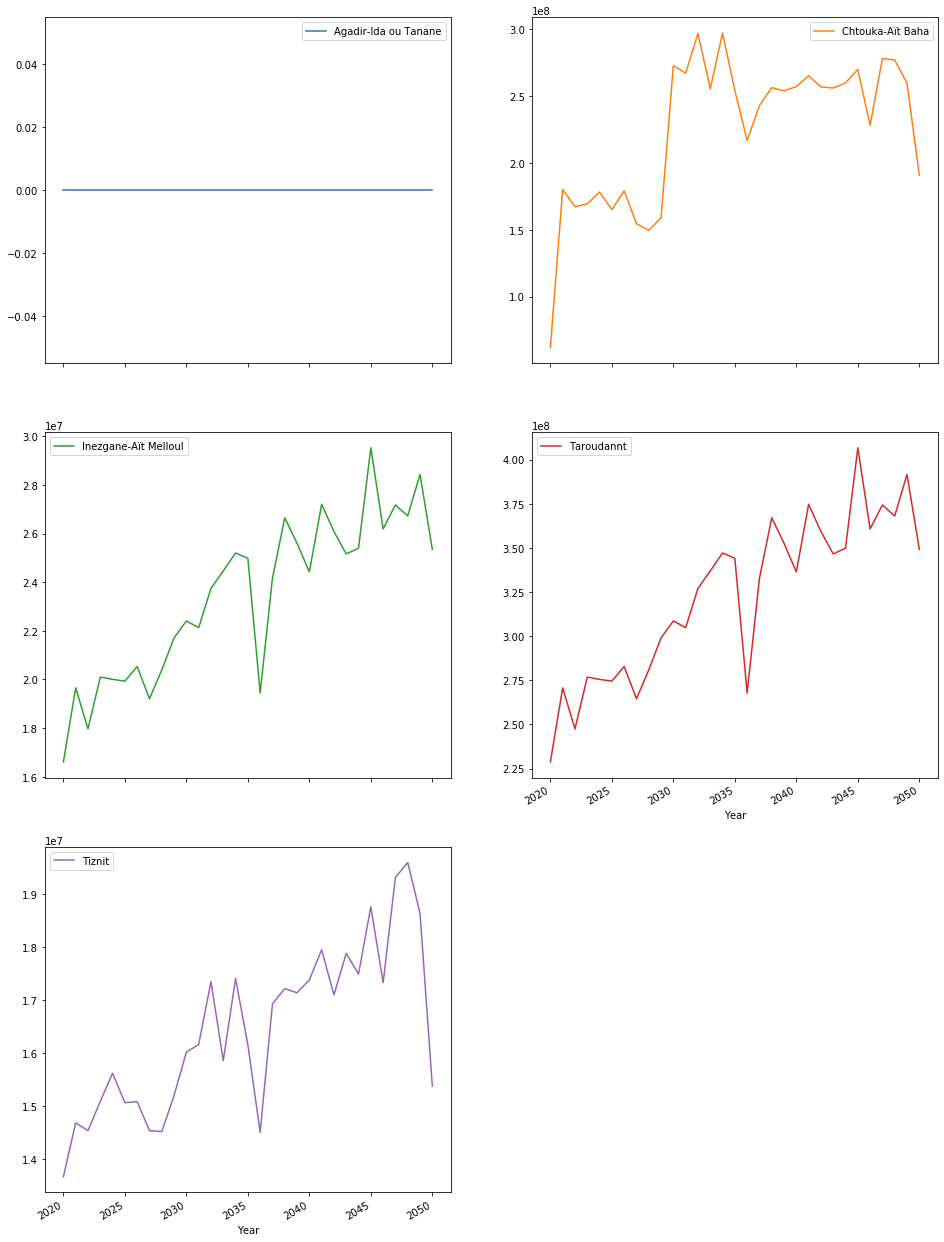

In [196]:
dff = sm_cropland.lcoe.reset_index().groupby(['province', 'Year']).sum().reset_index().dropna().pivot('Year','province','energy demand')
amount = dff.columns.shape[0] + 1
dff.plot(subplots=True,
         layout=(int(amount/2), 2),
         figsize=(16,24),
#          sharey=True
        )

In [326]:
df = sm_cropland.technologies['Solar PV'].lcoe
df.loc[(df.year==2020)].lcoe.max()
# inx = df.loc[(df.year==2020)&(df.lcoe>=1)].index
# df.loc[(df.year==2020)&(df.lcoe<=0.14)]

0.36843990512725444

In [106]:
df = sm_cropland.lcoe.dropna()
df.reset_index().pivot('Year','Demand point','least_cost_technology')

Demand point,0,1,2,3,4,5,6,7,8,9,...,7569,7570,7571,7572,7573,7574,7575,7576,7577,7578
Year,,,,,,,,,,,,,,,,,,,,,
2020,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,...,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV
2021,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,...,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV
2022,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,...,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV
2023,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,...,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV
2024,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,...,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV
2025,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,...,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV
2026,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,...,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV
2027,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,...,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV
2028,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,...,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV


In [313]:
import geopandas as gpd

cropland = gpd.read_file(r"Data - Souss-Massa\GIS\Processed layers\cropland_2013_processed_20200218_clean.csv", encoding='utf-8')

In [314]:
import contextily as ctx

In [315]:
df = sm_cropland.lcoe.reset_index()

df = df.loc[(df.Year==2048)]
df['geometry'] = df['Demand point'].map(cropland.geometry)
df = gpd.GeoDataFrame(df, crs='epsg:26192')
df.to_crs('epsg:3857', inplace=True)
provinces = gpd.read_file('Data - Souss-Massa/GIS/Admin/Provinces.gpkg', encoding='utf-8')
provinces.to_crs('epsg:3857', inplace=True)

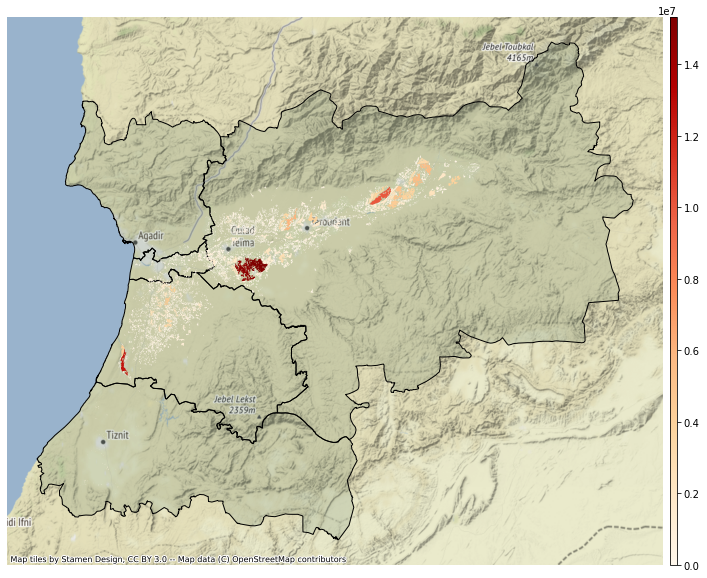

In [316]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.1)

provinces.plot(color=(0.4,0.5,0.4,0.2), edgecolor='black', ax=ax)
df.plot(column='energy demand', ax=ax, cmap='OrRd', legend=True, cax=cax)
ctx.add_basemap(ax)
ax.set_axis_off()
# fig.savefig('testPlotEnergy.png', dpi=300)

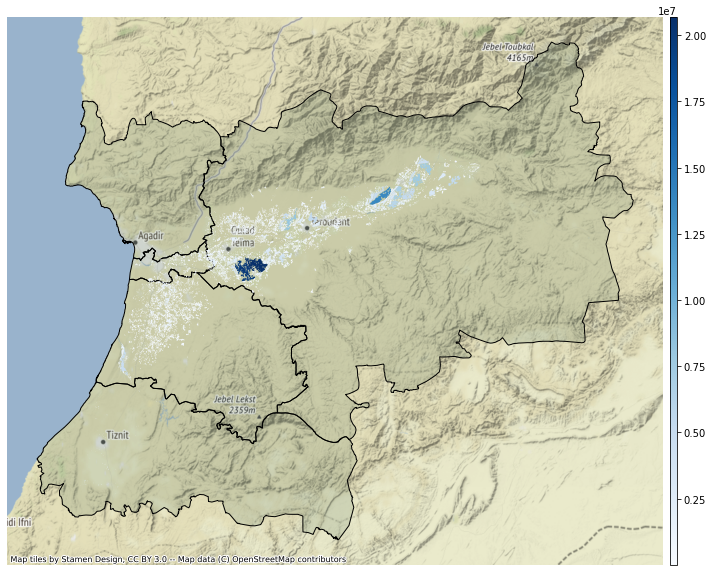

In [317]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.1)

provinces.plot(color=(0.4,0.5,0.4,0.2), edgecolor='black', ax=ax)
df.plot(column='water demand', ax=ax, cmap='Blues', legend=True, cax=cax)
ctx.add_basemap(ax)
ax.set_axis_off()
# fig.savefig('testPlotWater.png', dpi=300)

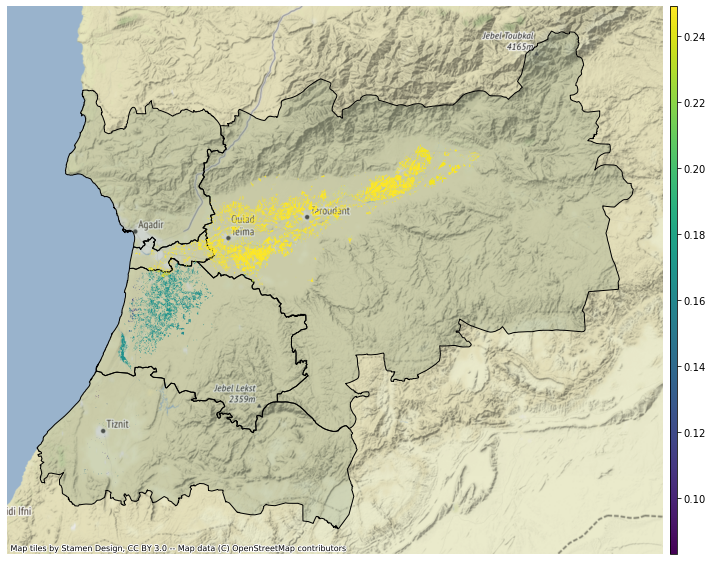

In [318]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.1)

provinces.plot(color=(0.4,0.5,0.4,0.2), edgecolor='black', ax=ax)
df.plot(column='lcoe', ax=ax, legend=True, cax=cax)
ctx.add_basemap(ax)
ax.set_axis_off()
# fig.savefig('testPlotLCOE.png', dpi=300)

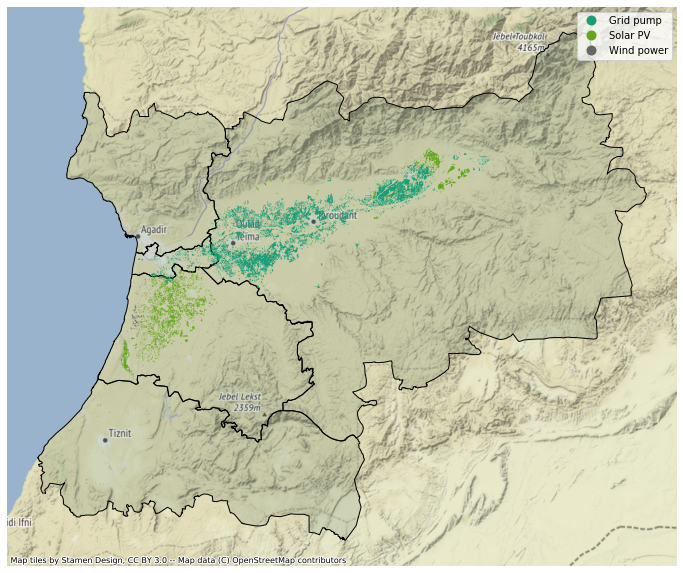

In [320]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

provinces.plot(color=(0.4,0.5,0.4,0.2), edgecolor='black', ax=ax)
df.plot(column='least_cost_technology', categorical=True, cmap='Dark2', ax=ax, legend=True, cax=cax)
ctx.add_basemap(ax)
ax.set_axis_off()
fig.savefig('testPlotLeastCost.png', dpi=300)

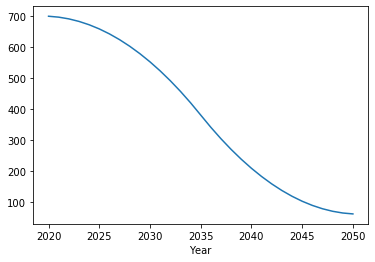

In [277]:
iyear = 2020
eyear = 2050
cp = 700
rate = 0.7
rates = {2020: 0, 2030: rate*0.3, 2040: rate, 2050: rate*1.3}
curve = create_learning_curve(iyear, eyear, cp, rates, 'polynomial')
curve.plot()

In [168]:
pd.core.series.Series

pandas.core.series.Series